In [1]:
# based on https://www.datacamp.com/community/tutorials/probability-distributions-python
# for inline plots in jupyter
# %matplotlib inline
# %matplotlib notebook
# # import matplotlib
# import matplotlib.pyplot as plt
# # for latex equations
# from IPython.display import Math, Latex
# # for displaying images
# from IPython.core.display import Image

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

# import seaborn as sns
# sns.set(color_codes=True)

import numpy as np
from numpy import random as rand
from scipy import stats

In [2]:
def plot_distribution(x, axs=None, figsize_=(15,8), bins_=100, kde_=True, cumulative_=False, xlabel='Distribution'):
    # plot the data
    if axs == None:
        fig, axs = plt.subplots(figsize=figsize_)
    axs.hist(x, density=False, bins=bins_, facecolor='b', alpha=0.5)
    axs.grid(alpha=0.75)
    axs.set_xlabel(xlabel)
    axs.set_ylabel('Count')

    # ax = sns.distplot(x,
    #                   bins=bins_,
    #                   kde=kde_,
    #                   hist_kws={'cumulative': cumulative_}, 
    #                   kde_kws={'cumulative': cumulative_},
    #                   color='skyblue')
    # ax.set(xlabel=xlabel, ylabel='Frequency')

def plot_ecdf(x, axs=None, figsize_=(15,8), bins_=100, xlabel='Data'):
    if axs == None:
        fig, axs = plt.subplots(figsize=figsize_)
    axs.hist(STOIIP,cumulative=True, density=True, bins=bins_, alpha=0.5)
    # plt.text(60, .025, '$P_{10}={:e},\\ P_{50}={:e},\\ P_90={:e}$'.format(p_10, p_50, p_90))
    axs.grid(alpha=0.75)
    axs.set_xlabel(xlabel)
    axs.set_ylabel('ECDF')

In [3]:
# number of Monte Carlo samples
# use the same for all Random Variables
n_samples = 1e6
n_samples = np.int64(n_samples)


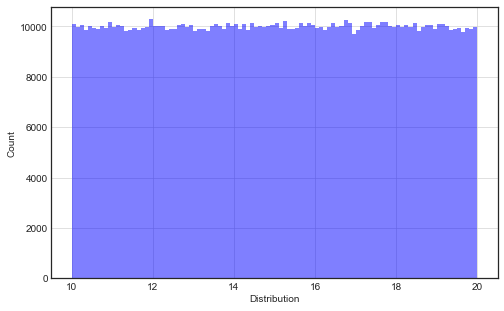

In [4]:
# random numbers from uniform distribution
lower_limit = 10
upper_limit = 20
x_uniform = rand.uniform(low=lower_limit, high=upper_limit, size=n_samples)
plot_distribution(x_uniform,figsize_=(8,5))

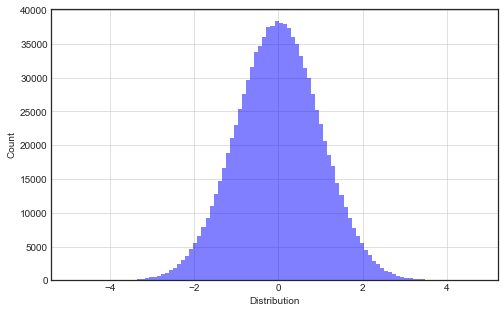

In [5]:
# generate random numbers from N(0,1)
x_mean = 0
x_std = 1
x_normal = rand.normal(loc=x_mean, scale=x_std, size=n_samples)
plot_distribution(x_normal,figsize_=(8,5))

Plot the logarithm of the distribution


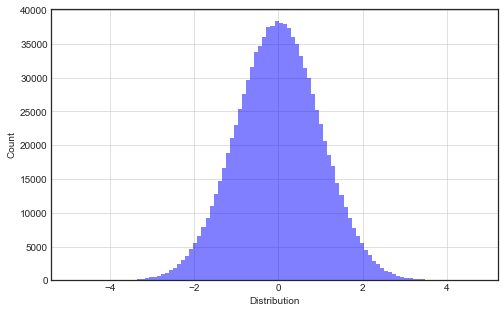

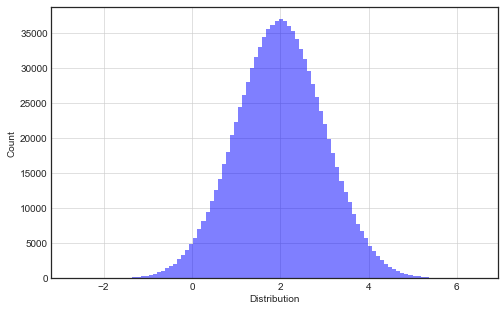

In [6]:
# generate log-normal random variable  --> always positive because it is exponential of Normal random variable 
# this distribution is defined in 
log_x_mean = 2
log_x_std = 1
x_lognormal = rand.lognormal(mean=log_x_mean, sigma=log_x_std, size=n_samples)
plot_distribution(x_normal,figsize_=(8,5))
print('Plot the logarithm of the distribution')
plot_distribution(np.log(x_lognormal),figsize_=(8,5))



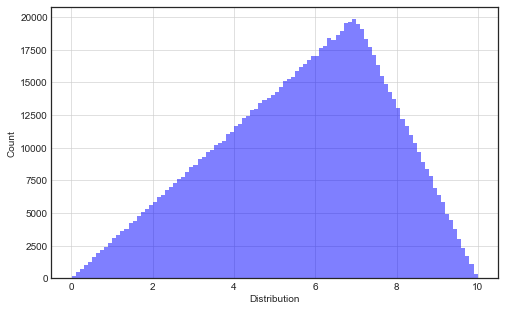

In [7]:
# generate random numbers from a triangular distribution
x_low = 0
x_mode = 7
x_high = 10
x_tri = rand.triangular(left=x_low, mode=x_mode, right=x_high, size=n_samples)
plot_distribution(x_tri,figsize_=(8,5))

In [8]:
# define data distributions
Bo= rand.uniform(low=1.19, high=1.21, size=n_samples) # units Bbl/STB
Sw = rand.uniform(low=0.19, high=0.45, size=n_samples)
porosity = rand.triangular(left=0.17, mode=0.213, right=0.24, size=n_samples)
NTG = rand.uniform(low=0.13, high=0.47, size=n_samples)
GRV = rand.triangular(left=0.55, mode=0.64, right=0.72, size=n_samples) # units 10^9 m3

In [9]:
# http://www.oilfieldwiki.com/wiki/Oil_in_place
# perform Monte Carlo simulation on the random variables 
STOIIP = 7758 * (GRV * 1e9) * porosity * (1 - Sw) / Bo # units barrels

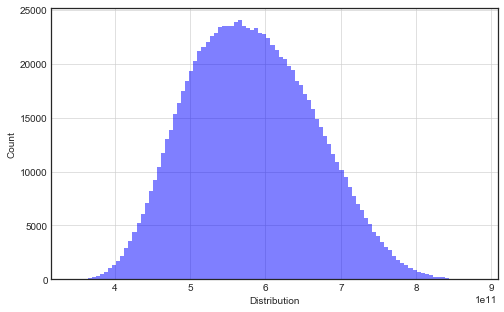

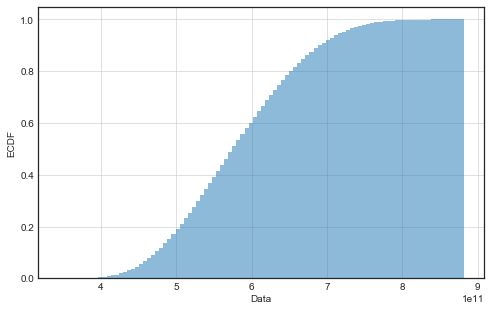

In [10]:
# plot the distribution
plot_distribution(STOIIP, figsize_=(8,5))

# plot CDF distribution --> make sure the bins_ is small
plot_ecdf(STOIIP, figsize_=(8,5))

In [11]:
def data_describe(x):
    [min_value, p_1, p_10, p_50, p_90, p_99, max_value] = np.percentile(x, [0, 1, 10, 50, 90, 99, 100])
    print('========================')
    print('Number of Monte Carlo Samples: {:d}'.format(len(x)))
    print('========================')
    print('min    : {:.7e}'.format(min_value))
    print('max    : {:.7e}'.format(max_value))
    print('mean   : {:.7e}'.format(x.mean()))
    print('median : {:.7e}'.format(np.median(x)))

    print('std    : {:.7e}'.format(x.std()))
    print('========================')
    print('Data percentiles')
    print('P1  : {:.7e}'.format(p_1))
    print('P10 : {:.7e}'.format(p_10))
    print('P50 : {:.7e}'.format(p_50))
    print('P90 : {:.7e}'.format(p_90))
    print('P99 : {:.7e}'.format(p_99))
    print('========================')

data_describe(STOIIP)

Number of Monte Carlo Samples: 1000000
min    : 3.4274275e+11
max    : 8.8135683e+11
mean   : 5.8143606e+11
median : 5.7751470e+11
std    : 8.2436642e+10
Data percentiles
P1  : 4.1648944e+11
P10 : 4.7605512e+11
P50 : 5.7751470e+11
P90 : 6.9300883e+11
P99 : 7.7250992e+11


finished MC calucation of STOIIP
Number of Monte Carlo Samples: 1000000
min    : 3.4274275e+05
max    : 8.8135683e+05
mean   : 5.8143606e+05
median : 5.7751470e+05
std    : 8.2436683e+04
Data percentiles
P1  : 4.1648944e+05
P10 : 4.7605512e+05
P50 : 5.7751470e+05
P90 : 6.9300883e+05
P99 : 7.7250992e+05
Sensitivity_analysis for STOIIP_GRV
Number of Monte Carlo Samples: 1000000
min    : 5.0247152e+05
max    : 6.5727575e+05
mean   : 5.8141900e+05
median : 5.8220124e+05
std    : 3.1705641e+04
Data percentiles
P1  : 5.1359903e+05
P10 : 5.3796869e+05
P50 : 5.8220124e+05
P90 : 6.2376620e+05
P99 : 6.4676978e+05
Sensitivity_analysis for STOIIP_porosity
Number of Monte Carlo Samples: 1000000
min    : 4.7603694e+05
max    : 6.7169665e+05
mean   : 5.8141900e+05
median : 5.8459361e+05
std    : 4.0339035e+04
Data percentiles
P1  : 4.9138686e+05
P10 : 5.2459975e+05
P50 : 5.8459361e+05
P90 : 6.3344167e+05
P99 : 6.5964208e+05
Sensitivity_analysis for STOIIP_Sw
Number of Monte Carlo Samples: 1000000
min

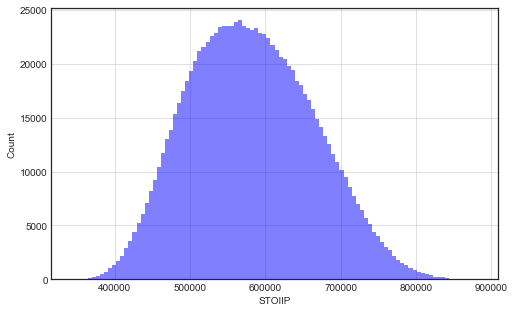

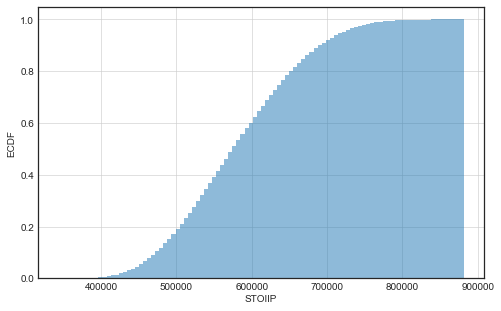

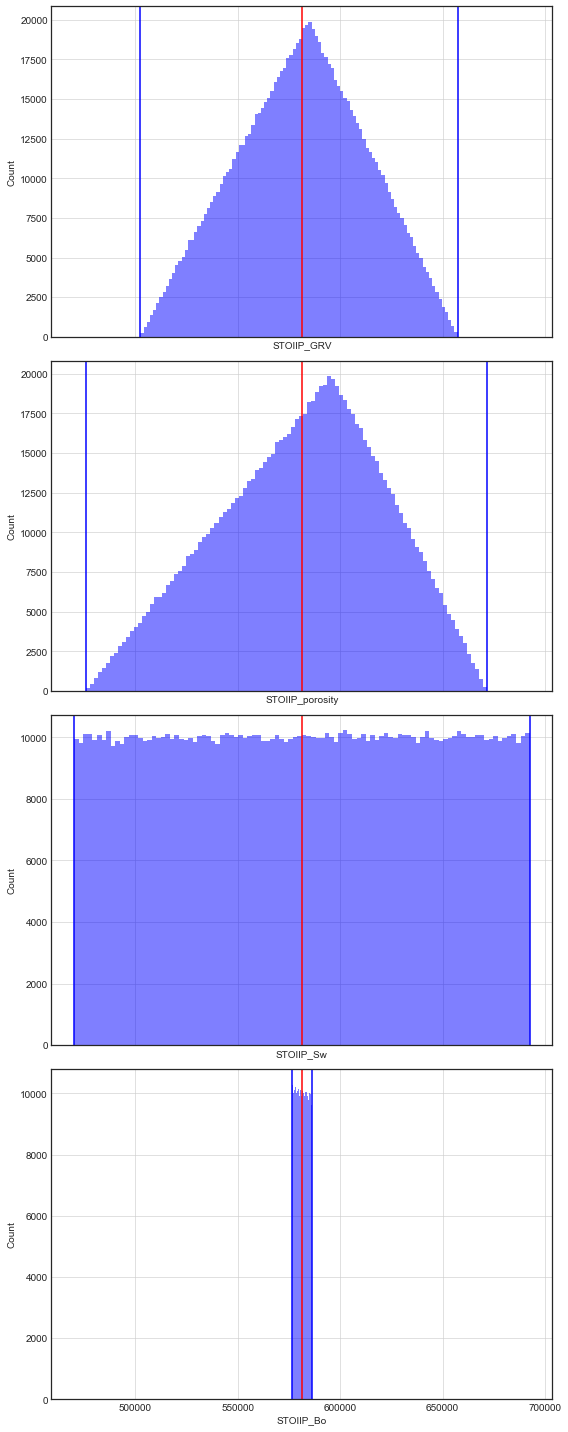

In [12]:
import pandas as pd

# define the calculations needed
def calculate_STOIIP(df):
    STOIIP = 7758 * (df['GRV'] * 1e3) * df['porosity']  * (1 - df['Sw']) / df['Bo'] # units barrels
    return STOIIP

# put your data into named tuples in a pandas.DataFrame 
data_df = pd.DataFrame()
data_df['GRV'] = GRV
data_df['porosity'] = porosity
data_df['Sw'] = Sw
data_df['Bo'] = Bo

# perform analysis
STOIIP = calculate_STOIIP(data_df)
print('finished MC calucation of STOIIP')
data_describe(STOIIP)
plot_distribution(STOIIP, figsize_=(8,5), xlabel='STOIIP')
plot_ecdf(STOIIP, figsize_=(8,5), xlabel='STOIIP')

def sensitivity_analysis(df):
    n_subfigures = len(df.columns)
    fig, axs = plt.subplots(n_subfigures, 1, sharex=True, tight_layout=True, figsize=(8,5*n_subfigures))
    sensitivity_df = df.copy()
    for idx_ , col_ in enumerate(df.columns):
        temp_df = df.copy()
        for temp_col_ in temp_df.columns:
            if temp_col_ == col_:
                continue
            temp_df[temp_col_] = temp_df[temp_col_].mean()
        # perform the calculations on temp_df
        temp_STOIIP = calculate_STOIIP(temp_df)
        sensitivity_df[col_] = temp_STOIIP
        plot_distribution(temp_STOIIP, axs=axs[idx_], xlabel='STOIIP_{}'.format(col_))
        print('Sensitivity_analysis for STOIIP_{}'.format(col_))
        data_describe(temp_STOIIP)

        axs[idx_].axvline(x=temp_STOIIP.mean(), color='r')
        axs[idx_].axvline(x=temp_STOIIP.min(), color='b')
        axs[idx_].axvline(x=temp_STOIIP.max(), color='b')
    return sensitivity_df
    
sensitivity_df = sensitivity_analysis(data_df)

# fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(12, 12))
# parts = axs.violinplot(
#         sensitivity_df, showmeans=False, showmedians=False,
#         showextrema=False)
# plt.show()

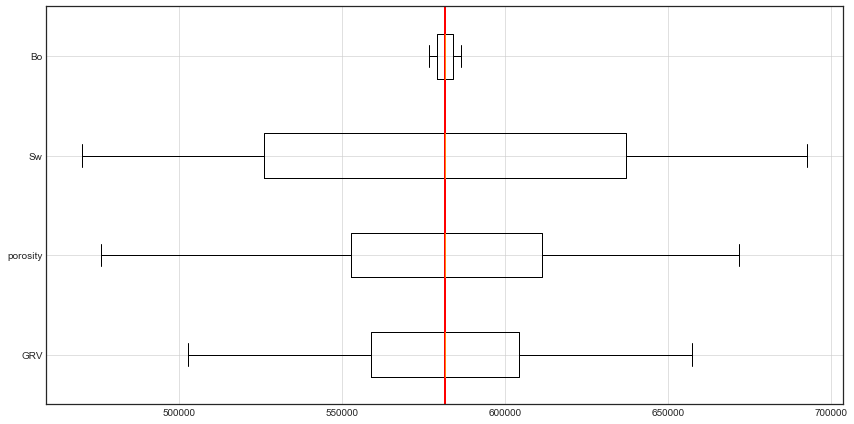

In [13]:
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(12, 6))
new_median = sensitivity_df.mean(axis=0).values
axs.boxplot(sensitivity_df.values, labels=sensitivity_df.columns, usermedians=new_median, vert=False)
axs.axvline(x=sensitivity_df.iloc[:,0].mean(), color='r', linewidth=2)
axs.grid(alpha=0.75)
# boxplot = sensitivity_df.boxplot()
# parts = axs.violinplot(
#         sensitivity_df, showmeans=False, showmedians=False,
#         showextrema=False)
plt.show()